In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from pathlib import Path
from keras import regularizers
import os.path
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping

In [2]:
images = pd.read_csv(r'./labels.csv')
images


,Image,Yaw,Pitch,Roll
0,/kaggle/input/images2/mst/0.png,0.0,-10,0
1,/kaggle/input/images2/mst/1.png,1.0,-10,0
2,/kaggle/input/images2/mst/-1.png,-1.0,-10,0
3,/kaggle/input/images2/mst/2.png,2.0,-10,0
4,/kaggle/input/images2/mst/-2.png,-2.0,-10,0
...,...,...,...,...
459,/kaggle/input/images2/mst/-29r4.png,-29.0,4,0
460,/kaggle/input/images2/mst/29_5r4.png,29.5,4,0
461,/kaggle/input/images2/mst/-29_5r4.png,-29.5,4,0
462,/kaggle/input/images2/mst/30r4.png,30.0,4,0


In [3]:
train_df, test_df = train_test_split(images, test_size=0.05, shuffle=True, random_state=1)

In [4]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=[0.75, 1],
    validation_split=0.05,
    rotation_angle = 3
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=[0.75, 1],
    validation_split=0.05,
    rotation_angle = 3
)

In [5]:
columns = ['Yaw', 'Pitch', 'Roll']

In [9]:
train=train_gen.flow_from_dataframe(
dataframe=train_df,
x_col="Image",
y_col=columns,
target_size=(128,128),
color_mode="rgb",
class_mode="raw",
batch_size=64,
shuffle=True,
seed=42,
subset="training")

Found 416 validated image filenames.


In [10]:
test=test_gen.flow_from_dataframe(
dataframe=test_df,
x_col="Image",
y_col=columns,
target_size=(128,128),
color_mode="rgb",
class_mode="raw",
batch_size=32,
shuffle=False)

Found 24 validated image filenames.


In [11]:
val_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image',
    y_col=columns,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 21 validated image filenames.


In [43]:
input=layers.Input(shape=(128,128,3))

x=layers.Conv2D(16,15,activation="relu")(input)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D((2,2))(x)

x=layers.Conv2D(32,12,activation="relu")(x)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D((2,2))(x)

x=layers.Conv2D(64,9,activation="relu")(x)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D((2,2))(x)

x=layers.Conv2D(60,6,activation="relu")(x)
x=layers.BatchNormalization()(x)
x=layers.MaxPooling2D((2,2))(x)

x=layers.Flatten()(x)
x=layers.Dense(128,activation="relu")(x)
x=layers.Dropout(0.1)(x)
x=layers.Dense(64,activation="relu")(x)
x=layers.Dropout(0.1)(x)
x=layers.Dense(500, kernel_regularizer=regularizers.l2(0.01), activation='relu')(x)

output=layers.Dense(3,activation="linear")(x)

model=Model(input,output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 114, 114, 16)      10816     
_________________________________________________________________
batch_normalization_114 (Bat (None, 114, 114, 16)      64        
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 57, 57, 16)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 46, 46, 32)        73760     
_________________________________________________________________
batch_normalization_115 (Bat (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 23, 23, 32)        0   

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005)
model.compile(optimizer,loss="mse")

In [80]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='val_loss')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss')

In [45]:
history=model.fit(train,validation_data=val_images,epochs=500)


2023-02-03 01:11:53.653249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2023-02-03 01:11:57.392174: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


7/7 [==============================] - 24s 2s/step - loss: 115.7108 - val_loss: 100.4761
Epoch 2/500
7/7 [==============================] - 4s 565ms/step - loss: 115.5345 - val_loss: 100.4718
Epoch 3/500
7/7 [==============================] - 3s 457ms/step - loss: 115.0770 - val_loss: 100.4506
Epoch 4/500
7/7 [==============================] - 3s 479ms/step - loss: 115.1122 - val_loss: 100.4469
Epoch 5/500
7/7 [==============================] - 4s 505ms/step - loss: 114.7825 - val_loss: 100.4361
Epoch 6/500
7/7 [==============================] - 3s 471ms/step - loss: 114.4200 - val_loss: 100.4292
Epoch 7/500
7/7 [==============================] - 3s 496ms/step - loss: 114.3003 - val_loss: 100.4209
Epoch 8/500
7/7 [==============================] - 3s 542ms/step - loss: 114.3015 - val_loss: 100.4107
Epoch 9/500
7/7 [==============================] - 3s 448ms/step - loss: 113.6900 - val_loss: 100.4059
Epoch 10/500
7/7 [==============================] - 3s 453ms/step - loss: 113.6111 - va

In [46]:
import plotly.express as px
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Model"
)

fig.show()

In [47]:
h = model.predict(test)
h

array([[-2.6484425e+01, -4.9166575e-01,  5.9999903e-03],
       [ 8.2174367e-01,  1.5823525e+00, -1.2212656e-02],
       [ 2.1821737e+01,  2.4941146e+00, -3.2649033e-02],
       [ 8.3842170e-01,  1.4984272e+00, -3.3219554e-02],
       [ 2.1654181e+01, -7.8731236e+00, -9.0749107e-02],
       [-6.8923368e+00,  2.4792325e+00, -8.6390473e-02],
       [-1.9951998e+01, -8.1334476e+00, -8.4131949e-02],
       [ 4.1615539e+00,  1.0508037e+00, -9.7436868e-02],
       [ 1.9746284e+01,  1.5798143e+00,  2.7510412e-02],
       [ 7.3921118e+00,  1.9019356e+00,  6.3701294e-02],
       [-1.5354698e+01,  2.4917374e+00, -2.9411130e-02],
       [ 2.1994062e+01, -9.0540543e+00, -2.2163020e-01],
       [ 2.2016838e+01,  1.7996624e+00, -2.1731876e-02],
       [-5.8142748e+00,  2.8963997e+00, -9.0596579e-02],
       [-2.0282888e+01,  2.9378941e+00, -3.9276078e-01],
       [-1.7594431e+01,  1.8954508e+00,  1.0770068e-01],
       [ 1.9798220e+01, -9.3864880e+00, -1.0816013e-01],
       [ 2.3312304e+01,  4.6613

In [48]:
test[0][1]

array([[-28. ,   0. ,   0. ],
       [ -0.5,   2. ,   0. ],
       [ 21.5,   4. ,   0. ],
       [  3. ,   2. ,   0. ],
       [ 19.5, -10. ,   0. ],
       [ -6. ,   2. ,   0. ],
       [-17.5, -10. ,   0. ],
       [  6. ,   2. ,   0. ],
       [ 18. ,   0. ,   0. ],
       [  6.5,   4. ,   0. ],
       [-15.5,   2. ,   0. ],
       [ 23. , -10. ,   0. ],
       [ 23.5,   2. ,   0. ],
       [ -7.5,   4. ,   0. ],
       [-21. ,   4. ,   0. ],
       [-17. ,   2. ,   0. ],
       [ 19. , -10. ,   0. ],
       [ 23. ,   0. ,   0. ],
       [-24. ,   0. ,   0. ],
       [-16.5,   4. ,   0. ],
       [ 17. ,   0. ,   0. ],
       [ 29.5,   0. ,   0. ],
       [ -2. , -10. ,   0. ],
       [-23. ,   2. ,   0. ]])

In [49]:
for i in range(len(test[0][1])):
    a = np.mean(abs(test[0][1][i][0] - h[i][0]))
a

0.6131153106689453

In [50]:
for i in range(len(test[0][1])):
    a = np.mean(abs(test[0][1][i][1] - h[i][1]))
a

0.6573739051818848

In [51]:
for i in range(len(test[0][1])):
    a = np.mean(abs(test[0][1][i][2] - h[i][2]))
a

0.11374291032552719

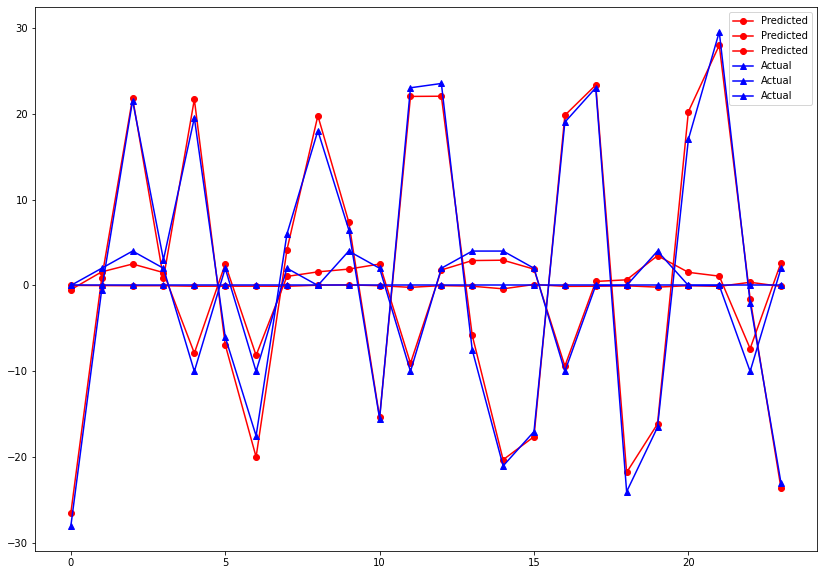

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))
plt.plot(h,'ro-',label = "Predicted")
plt.plot(test[0][1],'b^-',label="Actual")
plt.legend()
plt.show()

In [89]:
model.save('model_weights.h5')

In [ ]:
model